In [1]:
import pandas as pd

df = pd.read_csv("../data/raw/creditcard.csv")
df.head

<bound method NDFrame.head of             Time         V1         V2        V3        V4        V5  \
0            0.0  -1.359807  -0.072781  2.536347  1.378155 -0.338321   
1            0.0   1.191857   0.266151  0.166480  0.448154  0.060018   
2            1.0  -1.358354  -1.340163  1.773209  0.379780 -0.503198   
3            1.0  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   
4            2.0  -1.158233   0.877737  1.548718  0.403034 -0.407193   
...          ...        ...        ...       ...       ...       ...   
284802  172786.0 -11.881118  10.071785 -9.834783 -2.066656 -5.364473   
284803  172787.0  -0.732789  -0.055080  2.035030 -0.738589  0.868229   
284804  172788.0   1.919565  -0.301254 -3.249640 -0.557828  2.630515   
284805  172788.0  -0.240440   0.530483  0.702510  0.689799 -0.377961   
284806  172792.0  -0.533413  -0.189733  0.703337 -0.506271 -0.012546   

              V6        V7        V8        V9  ...       V21       V22  \
0       0.462388  0.239599  0.

Class
0    284315
1       492
Name: count, dtype: int64


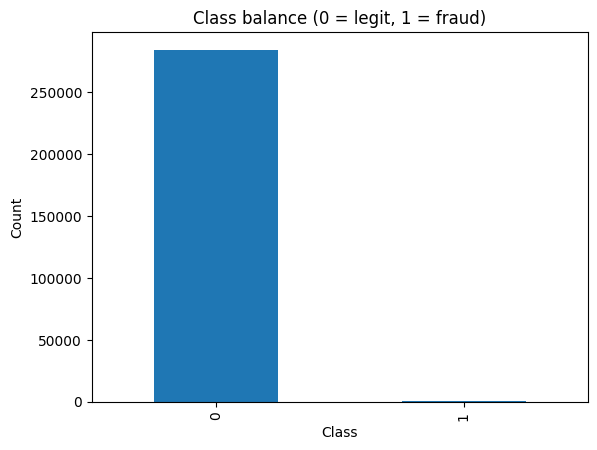

In [2]:
import matplotlib.pyplot as plt

class_counts = df["Class"].value_counts().sort_index()
print(class_counts)

plt.figure()
class_counts.plot(kind='bar')
plt.title("Class balance (0 = legit, 1 = fraud)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

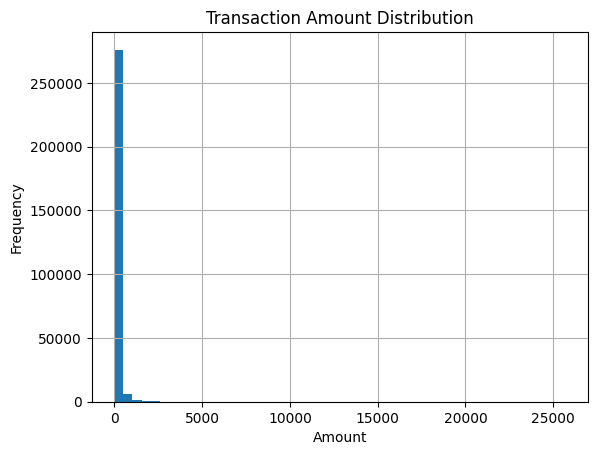

In [3]:
df["Amount"].hist(bins=50)
plt.title("Transaction Amount Distribution")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()

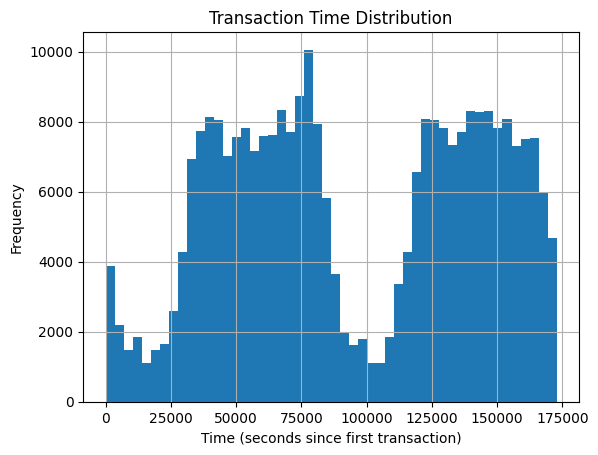

In [4]:
df["Time"].hist(bins=50)
plt.title("Transaction Time Distribution")
plt.xlabel("Time (seconds since first transaction)")
plt.ylabel("Frequency")
plt.show()

In [5]:
df["Hour"] = (df["Time"] // 3600).astype(int)
df[["Time", "Hour"]].head()

,Time,Hour
0,0.0,0
1,0.0,0
2,1.0,0
3,1.0,0
4,2.0,0


In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[["Time", "Amount"]] = scaler.fit_transform(df[["Time", "Amount"]])
df[["Time", "Amount"]].head()

,Time,Amount
0,-1.996583,0.244964
1,-1.996583,-0.342475
2,-1.996562,1.160686
3,-1.996562,0.140534
4,-1.996541,-0.073403


In [10]:
from pathlib import Path

out_dir = Path("../data/processed")
out_dir.mkdir(parents=True, exist_ok=True)

out_path = out_dir / "creditcard_processed.csv"

df.to_csv(out_path, index=False)
out_path, out_path.exists()

(PosixPath('../data/processed/creditcard_processed.csv'), True)

In [11]:
import pandas as pd

df2 = pd.read_csv("../data/processed/creditcard_processed.csv")
print("Original shape:", df.shape)
print("Reloaded shape:", df2.shape)
df2[["Time", "Amount", "Hour"]].head()

Original shape: (284807, 32)
Reloaded shape: (284807, 32)


,Time,Amount,Hour
0,-1.996583,0.244964,0
1,-1.996583,-0.342475,0
2,-1.996562,1.160686,0
3,-1.996562,0.140534,0
4,-1.996541,-0.073403,0


In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# load processed data
df = pd.read_csv("../data/processed/creditcard_processed.csv")

X = df.drop(columns=["Class"])
y = df["Class"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

y_prob = clf.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred, digits=4))


ROC-AUC: 0.9589227573415409
              precision    recall  f1-score   support

           0     0.9994    0.9998    0.9996     56864
           1     0.8205    0.6531    0.7273        98

    accuracy                         0.9992     56962
   macro avg     0.9100    0.8264    0.8634     56962
weighted avg     0.9991    0.9992    0.9991     56962



In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# reload to be safe
df = pd.read_csv("../data/processed/creditcard_processed.csv")
X = df.drop(columns=["Class"])
y = df["Class"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

clf = LogisticRegression(max_iter=2000, class_weight="balanced")
clf.fit(X_train, y_train)

y_prob = clf.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred, digits=4))

ROC-AUC: 0.9720050812249492
              precision    recall  f1-score   support

           0     0.9999    0.9755    0.9875     56864
           1     0.0606    0.9184    0.1136        98

    accuracy                         0.9754     56962
   macro avg     0.5302    0.9469    0.5506     56962
weighted avg     0.9982    0.9754    0.9860     56962



In [15]:
import numpy as np
from sklearn.metrics import precision_recall_curve, classification_report, roc_auc_score, average_precision_score

# uses y_prob from your last model cell
prec, rec, thr = precision_recall_curve(y_test, y_prob)

# align lengths (thr has one fewer element)
prec_t, rec_t = prec[:-1], rec[:-1]

# maximize F2 (recall-heavy)
beta = 2.0
f2 = (1 + beta**2) * (prec_t * rec_t) / (beta**2 * prec_t + rec_t + 1e-12)
best_idx = int(np.nanargmax(f2))
best_thr = float(thr[best_idx])

y_pred_tuned = (y_prob >= best_thr).astype(int)

print("Chosen threshold:", best_thr)
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("Average Precision (PR-AUC):", average_precision_score(y_test, y_prob))
print(classification_report(y_test, y_pred_tuned, digits=4))


Chosen threshold: 0.9999848943985182
ROC-AUC: 0.9720050812249492
Average Precision (PR-AUC): 0.7191143126701435
              precision    recall  f1-score   support

           0     0.9997    0.9996    0.9997     56864
           1     0.7810    0.8367    0.8079        98

    accuracy                         0.9993     56962
   macro avg     0.8903    0.9182    0.9038     56962
weighted avg     0.9993    0.9993    0.9993     56962



In [16]:
import joblib
from pathlib import Path

model_dir = Path("../models")
model_dir.mkdir(parents=True, exist_ok=True)
bundle_path = model_dir / "best_model.joblib"

feature_names = list(X.columns)  # from your training cell

joblib.dump(
    {
        "model": clf,          # your class-weighted logistic regression
        "threshold": best_thr, # from the F2 tuning cell
        "features": feature_names,
        # NOTE: we scaled in the dataset already; if you later move scaling into code, save the scaler here too.
    },
    bundle_path,
)

bundle_path, bundle_path.exists()


(PosixPath('../models/best_model.joblib'), True)